Libraries:

In [3]:
import numpy as np
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
# Additional functions for online compilers
import requests
from io import BytesIO

Matplotlib is building the font cache; this may take a moment.


Image matrix normalizing and displaying functions:

In [4]:
def normalize_image_matrix(img_matrix):
    """
    Normalize image matrix to [0, 1] range
    
    Args:
        img_matrix (numpy.ndarray): Image matrix
        
    Returns:
        numpy.ndarray: Normalized image matrix
    """
    return img_matrix.astype(np.float32) / 255.0

def display_matrix_info(img_matrix):
    """
    Display detailed information about the image matrix
    
    Args:
        img_matrix (numpy.ndarray): Image matrix
    """
    print("=== Image Matrix Information ===")
    print(f"Shape: {img_matrix.shape}")
    print(f"Dimensions: {img_matrix.ndim}")
    print(f"Data type: {img_matrix.dtype}")
    print(f"Size (total elements): {img_matrix.size}")
    print(f"Memory usage: {img_matrix.nbytes} bytes")
    print(f"Min value: {img_matrix.min()}")
    print(f"Max value: {img_matrix.max()}")
    print(f"Mean value: {img_matrix.mean():.2f}")
    print(f"Standard deviation: {img_matrix.std():.2f}")
    
    if img_matrix.ndim == 3:
        print(f"Number of channels: {img_matrix.shape[2]}")
        print("Channel-wise statistics:")
        for i in range(img_matrix.shape[2]):
            channel_name = ['Red', 'Green', 'Blue'][i] if img_matrix.shape[2] == 3 else f'Channel {i}'
            print(f"  {channel_name}: min={img_matrix[:,:,i].min()}, max={img_matrix[:,:,i].max()}, mean={img_matrix[:,:,i].mean():.2f}")

def visualize_matrix(img_matrix, title="Image Matrix"):
    """
    Visualize the image matrix
    
    Args:
        img_matrix (numpy.ndarray): Image matrix
        title (str): Title for the plot
    """
    plt.figure(figsize=(10, 8))
    
    if img_matrix.ndim == 2:  # Grayscale
        plt.imshow(img_matrix, cmap='gray')
    else:  # Color
        plt.imshow(img_matrix)
    
    plt.title(title)
    plt.axis('off')
    plt.colorbar()
    plt.show()

Image-to-Matrix exchanging and displaying a matrix as an image:

In [5]:
def matrix_to_image(img_matrix, output_path=None):
    """
    Convert matrix back to image and optionally save it
    
    Args:
        img_matrix (numpy.ndarray): Image matrix
        output_path (str, optional): Path to save the image
        
    Returns:
        PIL.Image: PIL Image object
    """
    # Handle different data types
    if img_matrix.dtype == np.float32 or img_matrix.dtype == np.float64:
        # If normalized (0-1 range), convert back to 0-255
        if img_matrix.max() <= 1.0:
            img_matrix = (img_matrix * 255).astype(np.uint8)
        else:
            img_matrix = img_matrix.astype(np.uint8)
    
    # Ensure values are in valid range
    img_matrix = np.clip(img_matrix, 0, 255)
    
    # Convert to PIL Image
    if img_matrix.ndim == 2:  # Grayscale
        img = Image.fromarray(img_matrix, mode='L')
    elif img_matrix.ndim == 3:  # Color
        if img_matrix.shape[2] == 3:  # RGB
            img = Image.fromarray(img_matrix, mode='RGB')
        elif img_matrix.shape[2] == 4:  # RGBA
            img = Image.fromarray(img_matrix, mode='RGBA')
        else:
            raise ValueError(f"Unsupported number of channels: {img_matrix.shape[2]}")
    else:
        raise ValueError(f"Unsupported matrix dimensions: {img_matrix.ndim}")
    
    # Save if path provided
    if output_path:
        img.save(output_path)
        print(f"Image saved to: {output_path}")
    
    return img

def display_matrix_as_image(img_matrix, title="Matrix as Image"):
    """
    Display matrix as image using matplotlib
    
    Args:
        img_matrix (numpy.ndarray): Image matrix
        title (str): Title for the display
    """
    plt.figure(figsize=(8, 6))
    
    if img_matrix.ndim == 2:  # Grayscale
        plt.imshow(img_matrix, cmap='gray')
    else:  # Color
        # Handle different data types
        display_matrix = img_matrix.copy()
        if display_matrix.dtype == np.float32 or display_matrix.dtype == np.float64:
            if display_matrix.max() <= 1.0:
                display_matrix = display_matrix
            else:
                display_matrix = display_matrix / 255.0
        else:
            display_matrix = display_matrix.astype(np.float32) / 255.0
        
        plt.imshow(display_matrix)
    
    plt.title(title)
    plt.axis('off')
    plt.show()

def matrix_to_base64(img_matrix):
    """
    Convert matrix to base64 string for web display
    
    Args:
        img_matrix (numpy.ndarray): Image matrix
        
    Returns:
        str: Base64 encoded image string
    """
    img = matrix_to_image(img_matrix)
    buffer = BytesIO()
    img.save(buffer, format='PNG')
    img_str = base64.b64encode(buffer.getvalue()).decode()
    return img_str

def compare_original_and_processed(original_matrix, processed_matrix):
    """
    Display original and processed images side by side
    
    Args:
        original_matrix (numpy.ndarray): Original image matrix
        processed_matrix (numpy.ndarray): Processed image matrix
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Original image
    if original_matrix.ndim == 2:
        ax1.imshow(original_matrix, cmap='gray')
    else:
        display_orig = original_matrix.copy()
        if display_orig.dtype != np.uint8:
            display_orig = np.clip(display_orig, 0, 255).astype(np.uint8)
        ax1.imshow(display_orig)
    ax1.set_title("Original")
    ax1.axis('off')
    
    # Processed image
    if processed_matrix.ndim == 2:
        ax2.imshow(processed_matrix, cmap='gray')
    else:
        display_proc = processed_matrix.copy()
        if display_proc.dtype != np.uint8:
            display_proc = np.clip(display_proc, 0, 255).astype(np.uint8)
        ax2.imshow(display_proc)
    ax2.set_title("Processed")
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()


def download_image_from_url(url):
    """
    Download image from URL for online compilers
    
    Args:
        url (str): URL of the image
        
    Returns:
        numpy.ndarray: Image matrix
    """
    try:
        response = requests.get(url)
        response.raise_for_status()
        
        # Open image from bytes
        img = Image.open(BytesIO(response.content))
        
        # Convert to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Convert to numpy array
        img_matrix = np.array(img)
        
        print(f"Downloaded image shape: {img_matrix.shape}")
        return img_matrix
        
    except Exception as e:
        print(f"Error downloading image: {e}")
        return None

        

Filtering functions: One returning a displayable highlighted image and the other returning a simple matrix of zeroes and ones:

In [6]:
def threshold_filter(img_matrix, threshold=128, highlight_color=(255, 0, 0), background_mode='original'):
    """
    Filter and highlight pixels with grayscale values below threshold
    
    Args:
        img_matrix (numpy.ndarray): Input image matrix (grayscale or color)
        threshold (int): Threshold value (0-255). Pixels below this are highlighted
        highlight_color (tuple): RGB color for highlighting (default: red)
        background_mode (str): How to handle non-highlighted pixels
            - 'original': Keep original colors
            - 'grayscale': Convert to grayscale
            - 'white': Make white background
            - 'black': Make black background
            - 'dim': Dim the original colors (50% brightness)
    
    Returns:
        numpy.ndarray: Filtered image matrix with highlighted pixels
    """
    # Convert to grayscale for threshold calculation
    if img_matrix.ndim == 3:  # Color image
        # Use luminance formula for grayscale conversion
        gray_values = np.dot(img_matrix[...,:3], [0.2989, 0.5870, 0.1140])
    else:  # Already grayscale
        gray_values = img_matrix.copy()
    
    # Create mask for pixels below threshold
    mask = gray_values < threshold
    
    # Create output matrix
    if img_matrix.ndim == 3:
        output_matrix = img_matrix.copy()
    else:
        # Convert grayscale to RGB for highlighting
        output_matrix = np.stack([img_matrix, img_matrix, img_matrix], axis=2)
    
    # Apply background mode
    if background_mode == 'grayscale':
        if img_matrix.ndim == 3:
            gray_expanded = np.stack([gray_values, gray_values, gray_values], axis=2)
            output_matrix = gray_expanded.astype(np.uint8)
        # else already grayscale converted to RGB above
    elif background_mode == 'white':
        output_matrix = np.ones_like(output_matrix) * 255
    elif background_mode == 'black':
        output_matrix = np.zeros_like(output_matrix)
    elif background_mode == 'dim':
        output_matrix = (output_matrix * 0.5).astype(np.uint8)
    # 'original' mode keeps the original colors
    
    # Apply highlight color to pixels below threshold
    output_matrix[mask] = highlight_color
    
    return output_matrix.astype(np.uint8)

def threshold_filter_b(img_matrix, threshold=128):
    """
    Filter and highlight pixels with grayscale values below threshold
    
    Args:
        img_matrix (numpy.ndarray): Input image matrix (grayscale or color)
        threshold (int): Threshold value (0-255). Pixels below this are highlighted
    
    Returns:
        numpy.ndarray: Filtered image matrix with highlighted pixels set to 1, all other pixels set to 0
    """
    # Convert to grayscale for threshold calculation
    if img_matrix.ndim == 3:  # Color image
        # Use luminance formula for grayscale conversion
        gray_values = np.dot(img_matrix[...,:3], [0.2989, 0.5870, 0.1140])
    else:  # Already grayscale
        gray_values = img_matrix.copy()
    
    # Create mask for pixels below threshold
    mask = gray_values < threshold

    output_matrix=np.zeros_like(gray_values)
    
    # Apply highlight color to pixels below threshold
    output_matrix[mask] = 1
    
    return output_matrix

Functions for counting connected regions and holes and vectorization:

In [7]:
def count_connected_regions_and_holes(grid):
    """
    Vectorized approach to counting connected regions and holes
    using scipy.ndimage for better performance.
    
    Args:
        grid: 2D NumPy array
    
    Returns:
        tuple: (num_regions, num_holes, region_hole_details)
    """
    
    from scipy.ndimage import label
    grid = np.asarray(grid)
    
    # Label nonzero regions
    binary_mask = grid != 0
    labeled_regions, num_regions = label(binary_mask)
    
    # Label zero regions (potential holes)
    zero_mask = grid == 0
    labeled_zeros, num_zero_components = label(zero_mask)
    
    # Check which zero components are holes (don't touch border)
    rows, cols = grid.shape
    border_labels = set()
    
    # Collect labels that touch the border
    if rows > 0 and cols > 0:
        # Top and bottom borders
        border_labels.update(labeled_zeros[0, :])
        border_labels.update(labeled_zeros[-1, :])
        # Left and right borders
        border_labels.update(labeled_zeros[:, 0])
        border_labels.update(labeled_zeros[:, -1])
    
    # Remove label 0 (background)
    border_labels.discard(0)
    
    # Count holes (zero components that don't touch border)
    total_holes = 0
    region_hole_details = []
    
    for region_id in range(1, num_regions + 1):
        holes_in_region = 0
        # This is a simplified count - in practice, you'd need to check
        # which holes are actually within each region
        total_holes = num_zero_components - len(border_labels)
        region_hole_details.append((region_id, 0))  # Simplified
    
    return num_regions, max(0, total_holes)

def betti_vector_filtration(img, N=50):
    """
    Produces a betti vector for an image
    Args:
        img: image matrix
        N: number of filtrations steps
    Returns:
        A Betti array of length N, consisting of tuples (H0, H1)
    """
    betti = np.empty([N,2]).astype(int)
    dt = 256/N
    for n in range(0,N-1) :

        e = round(dt*n)
        # Main part:
        filtered = threshold_filter_b(img_matrix, threshold = e)
        h0, h1 = count_connected_regions_and_holes(filtered)
        betti[n] = (h0, h1)

    # OPTIONAL: Highlight dark pixels in pink and display homology groups
        pink_filtered = threshold_filter(img_matrix, threshold = e, highlight_color=(245, 50, 140))
        display_matrix_as_image(pink_filtered, f"N = {n}, Threshold = {e}")
        
        print(f'H0 = {h0}, H1 = {h1}')
        
    return betti

Main code


1. Downloading image from URL...
Downloaded image shape: (386, 686, 3)
Successfully downloaded image


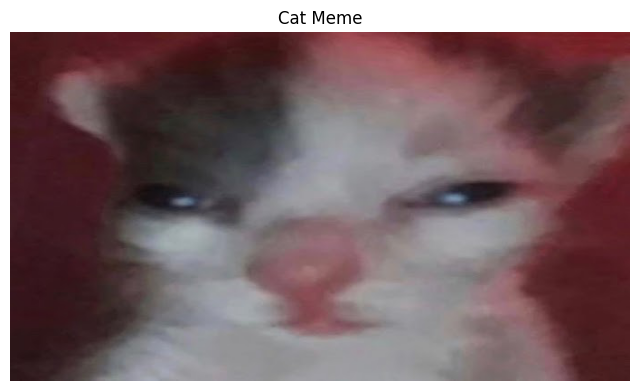

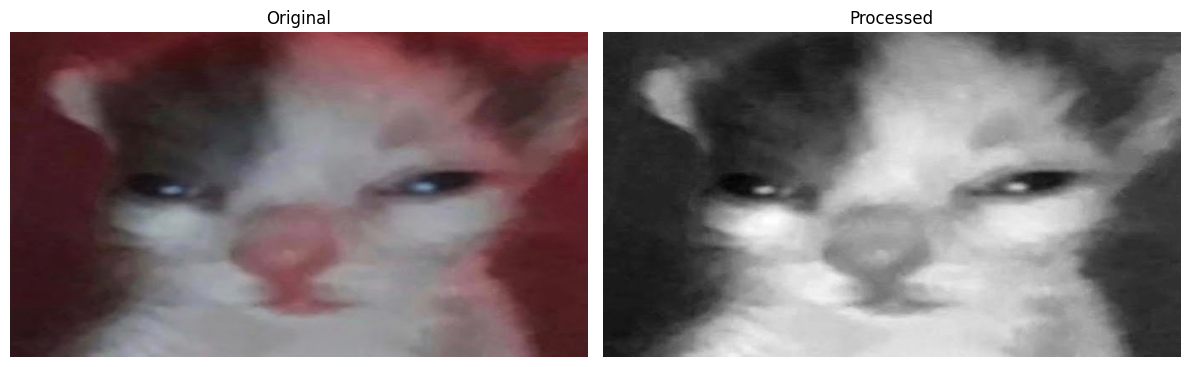

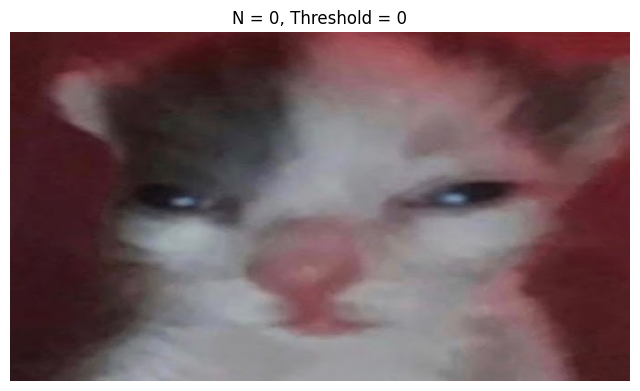

H0 = 0, H1 = 0


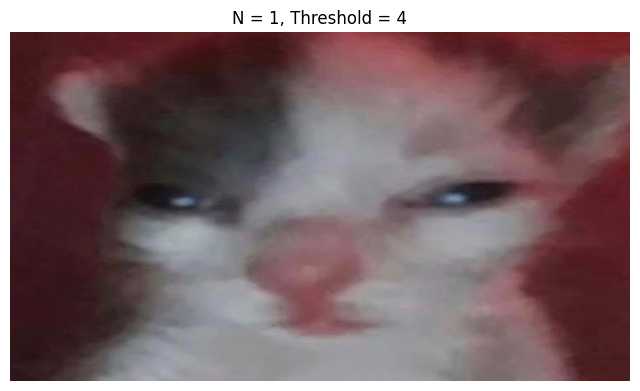

H0 = 0, H1 = 0


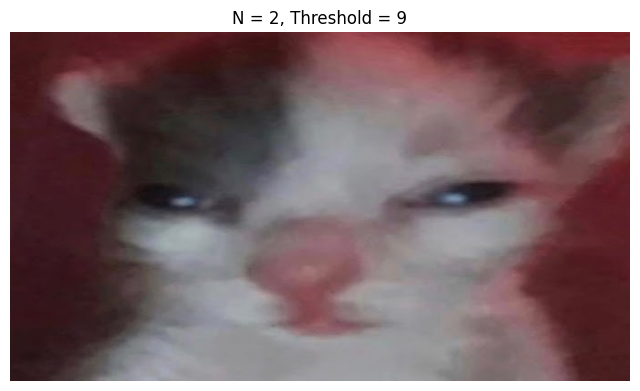

H0 = 0, H1 = 0


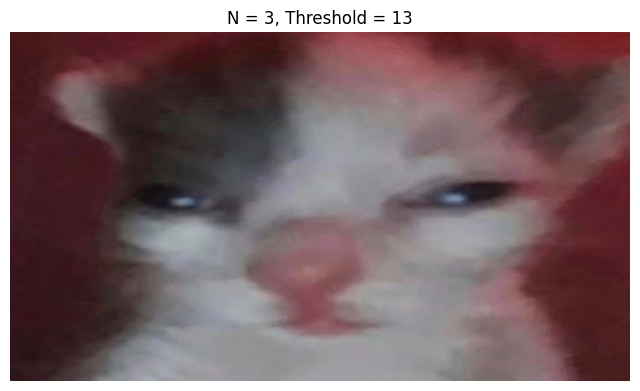

H0 = 0, H1 = 0


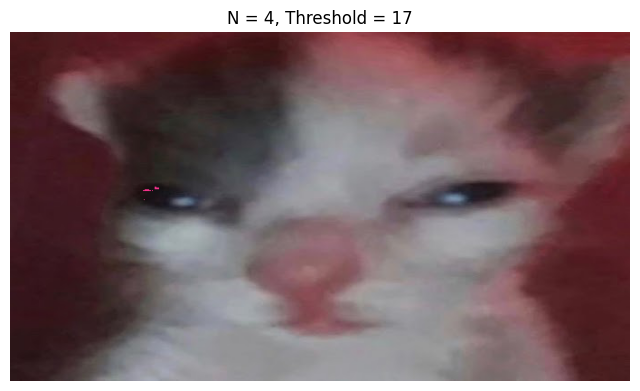

H0 = 4, H1 = 0


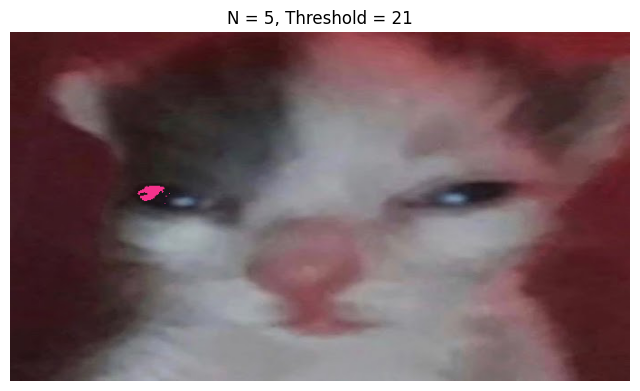

H0 = 4, H1 = 0


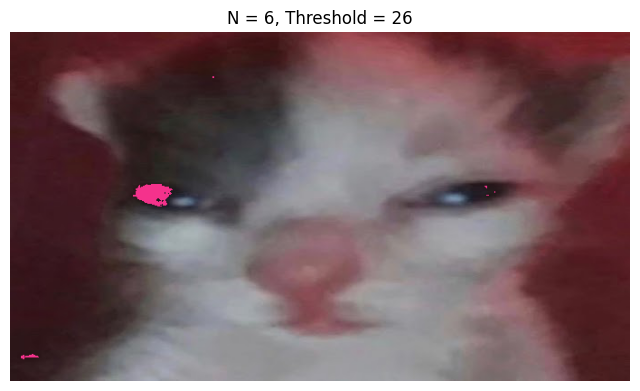

H0 = 6, H1 = 4


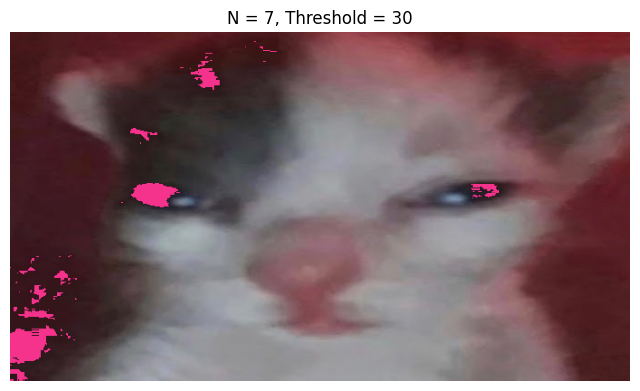

H0 = 64, H1 = 6


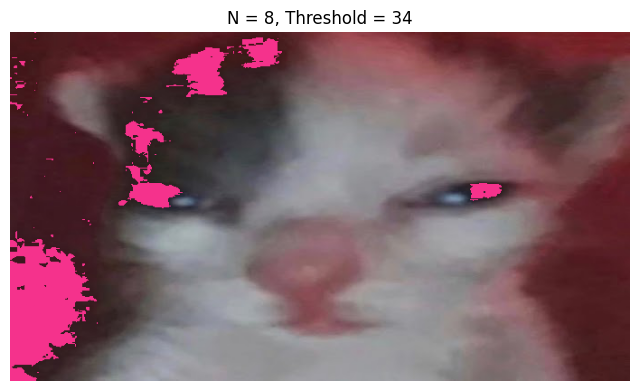

H0 = 68, H1 = 21


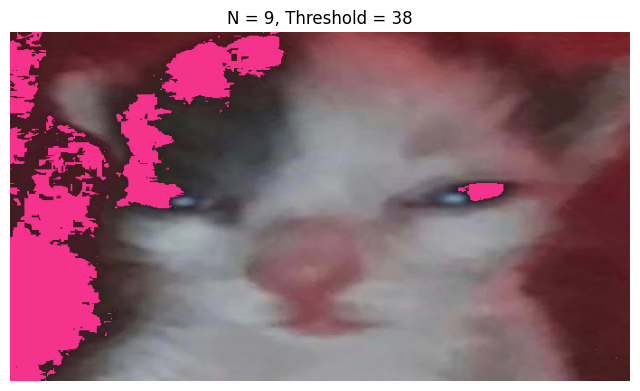

H0 = 78, H1 = 44


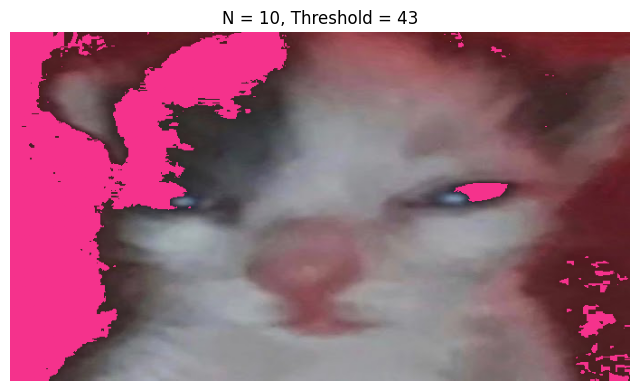

H0 = 82, H1 = 49


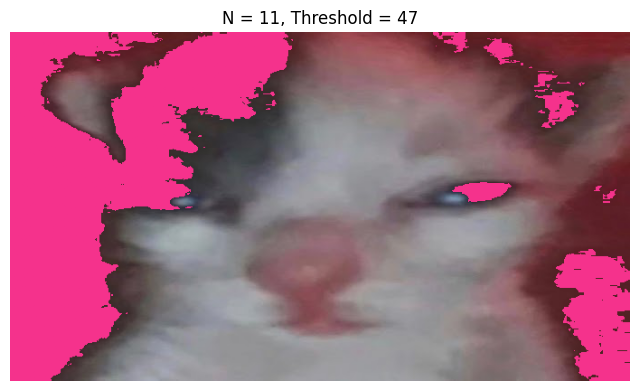

H0 = 56, H1 = 48


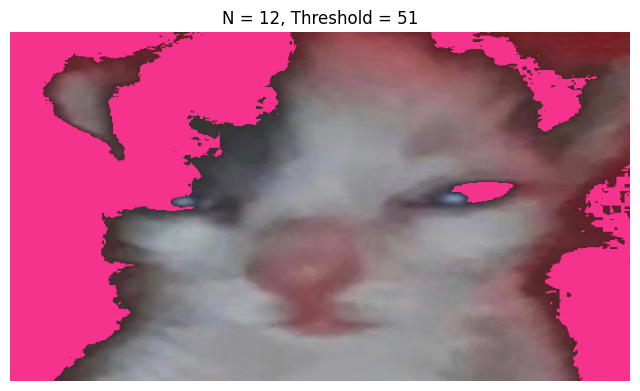

H0 = 38, H1 = 56


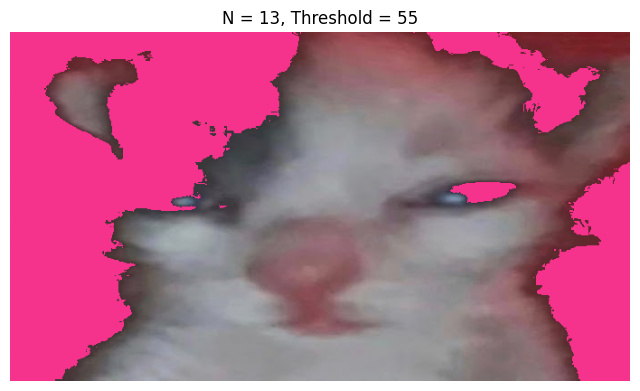

H0 = 40, H1 = 39


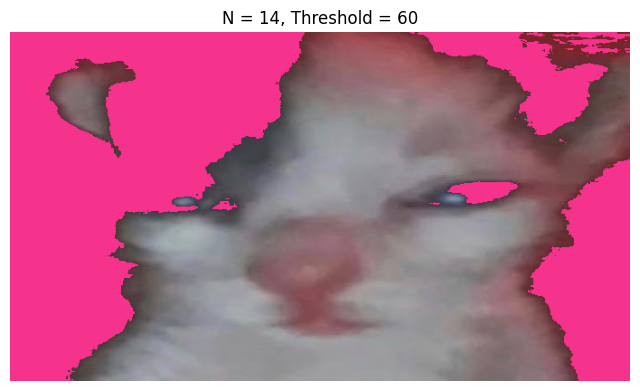

H0 = 34, H1 = 23


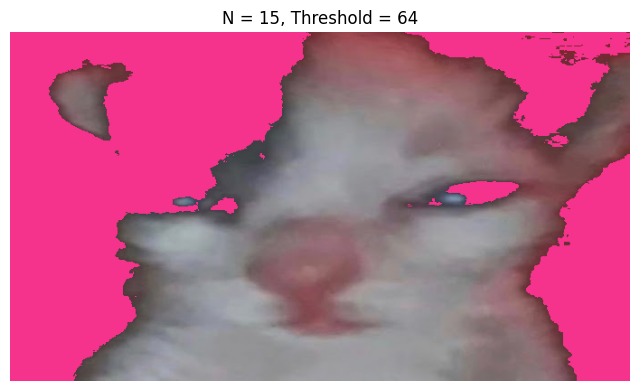

H0 = 24, H1 = 32


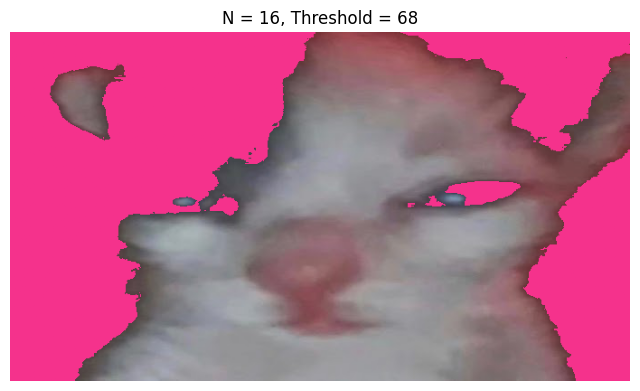

H0 = 19, H1 = 12


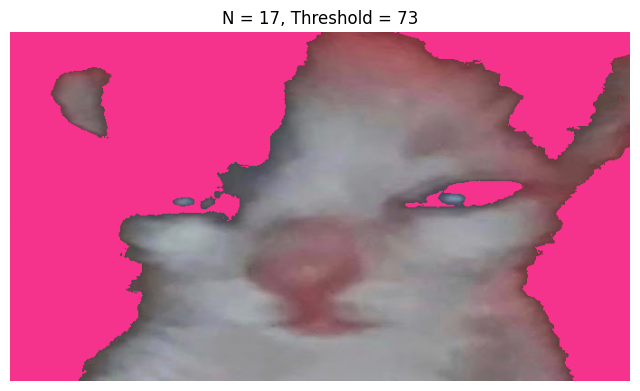

H0 = 20, H1 = 12


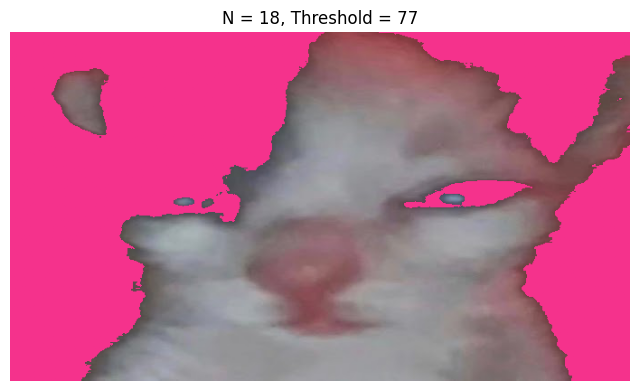

H0 = 15, H1 = 14


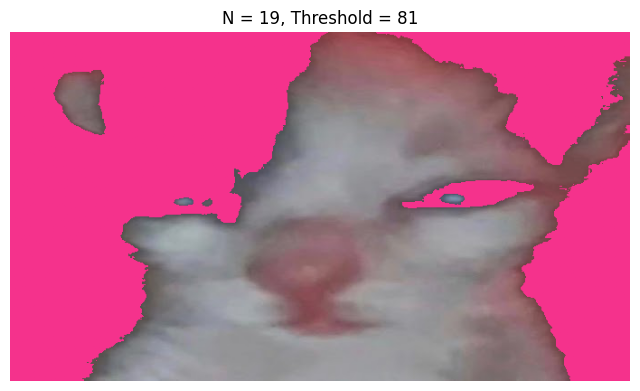

H0 = 22, H1 = 11


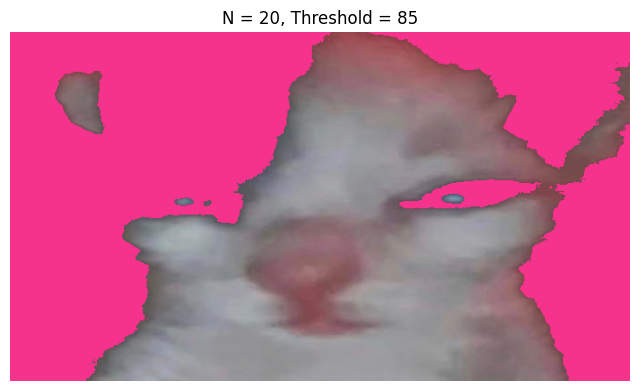

H0 = 13, H1 = 18


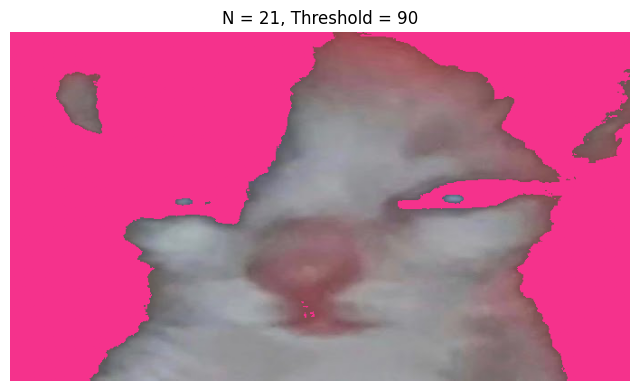

H0 = 18, H1 = 18


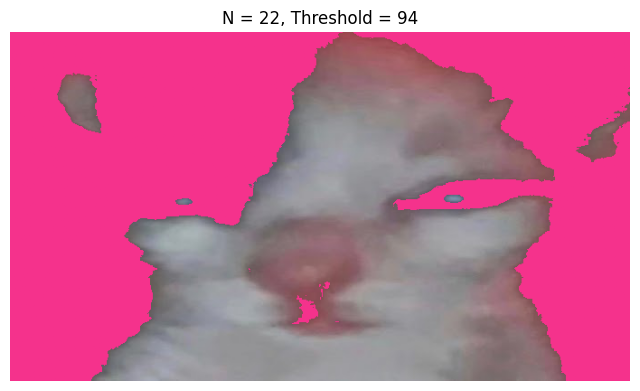

H0 = 15, H1 = 15


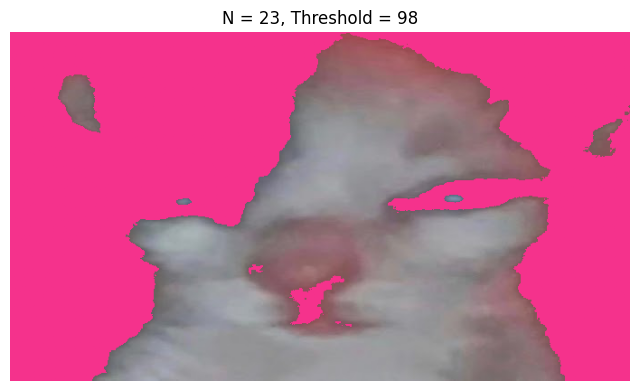

H0 = 13, H1 = 13


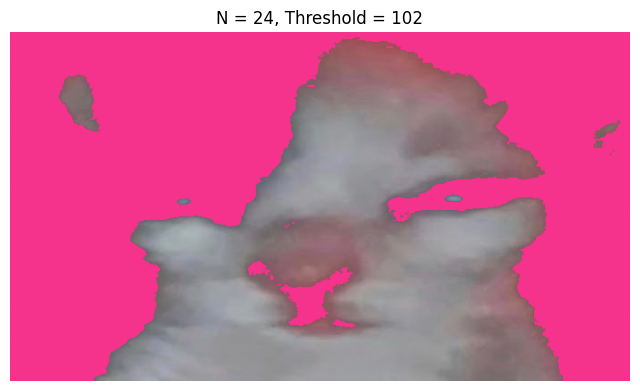

H0 = 22, H1 = 18


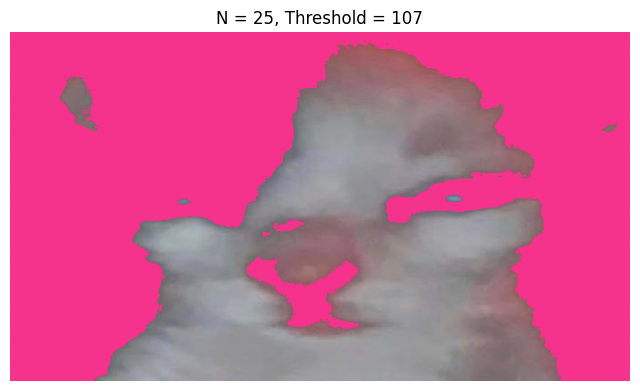

H0 = 17, H1 = 18


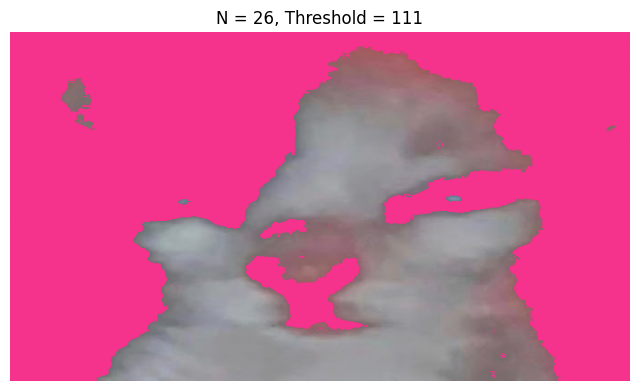

H0 = 37, H1 = 19


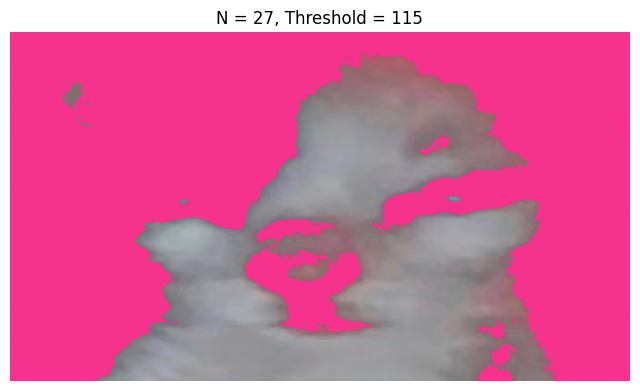

H0 = 45, H1 = 44


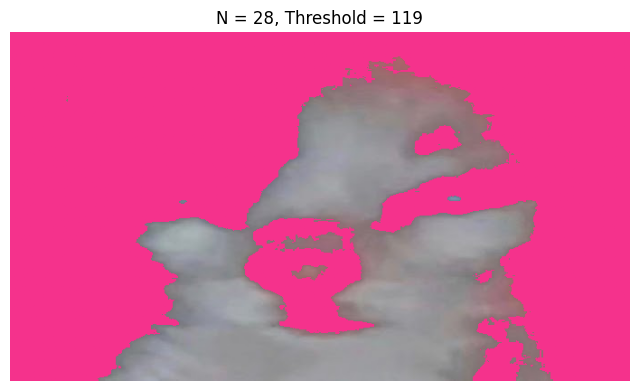

H0 = 31, H1 = 44


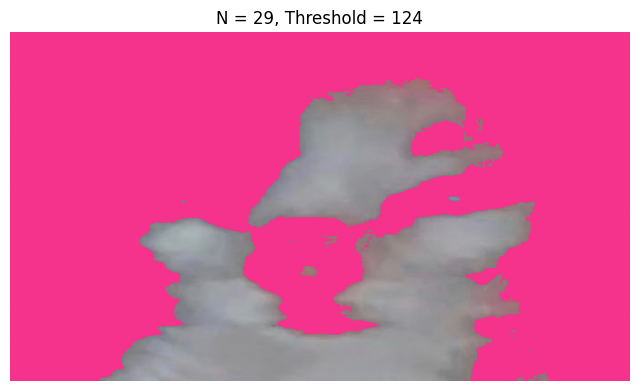

H0 = 25, H1 = 36


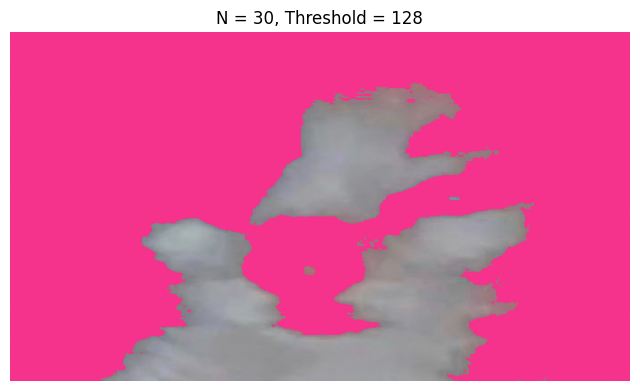

H0 = 27, H1 = 20


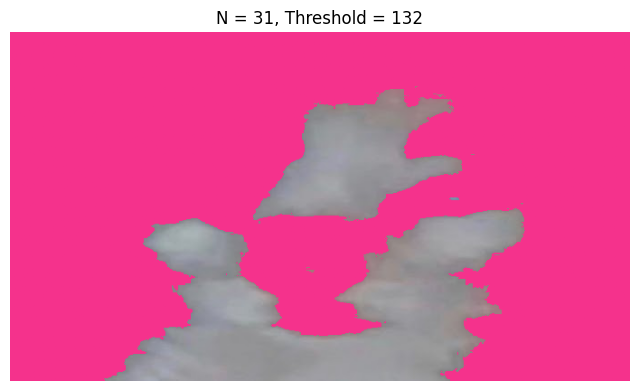

H0 = 18, H1 = 23


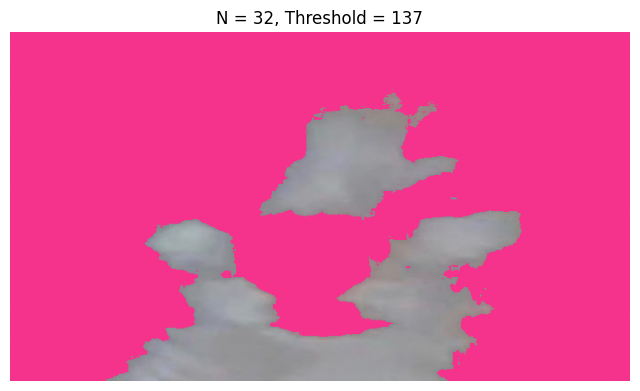

H0 = 17, H1 = 22


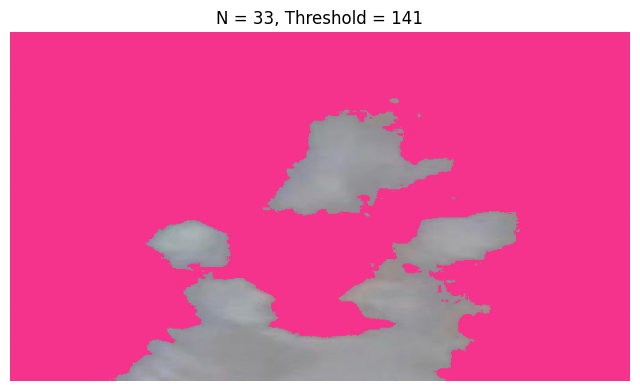

H0 = 16, H1 = 28


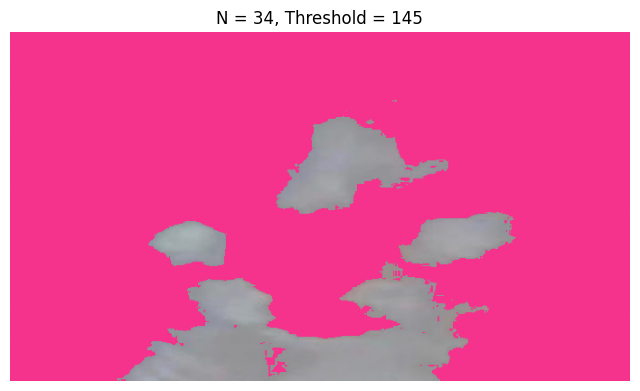

H0 = 47, H1 = 25


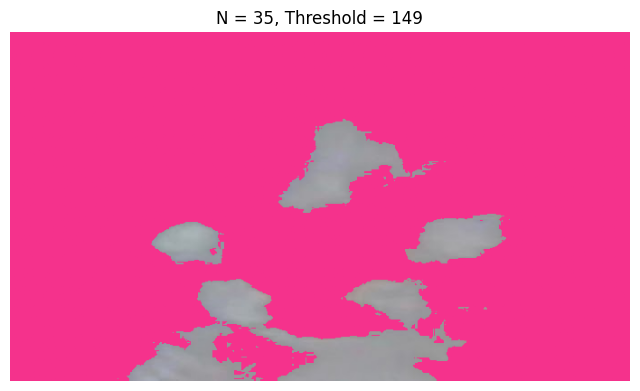

H0 = 24, H1 = 41


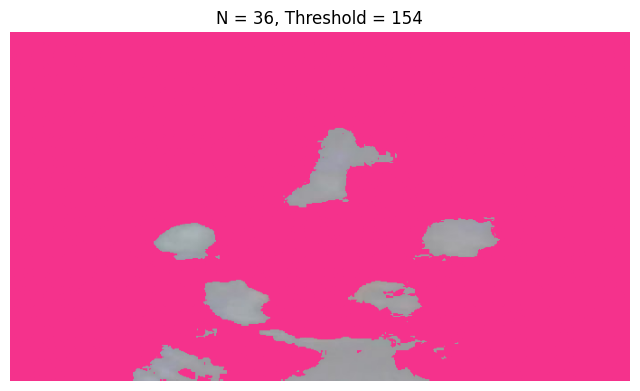

H0 = 21, H1 = 37


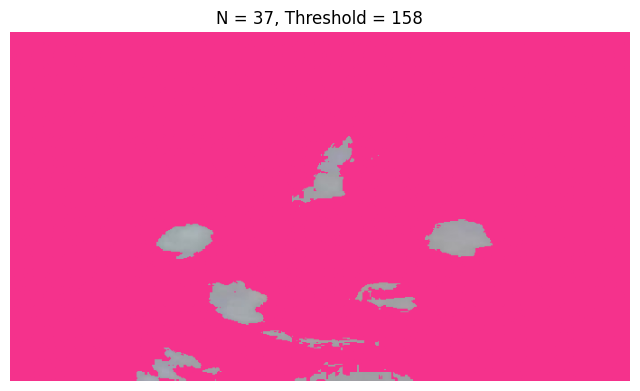

H0 = 20, H1 = 36


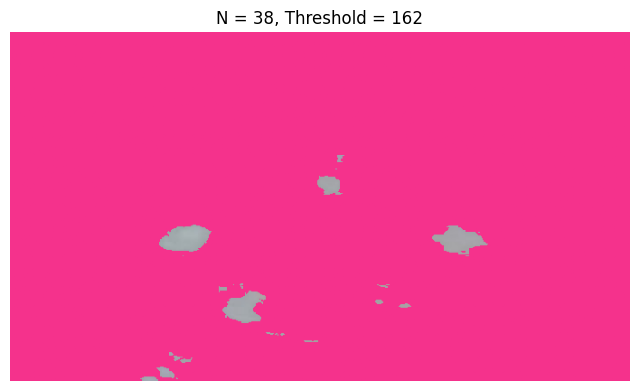

H0 = 3, H1 = 27


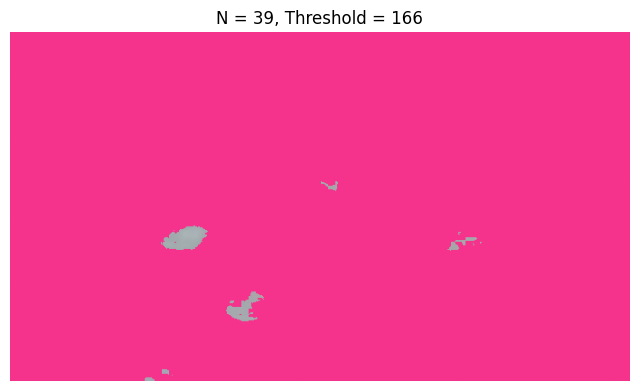

H0 = 3, H1 = 15


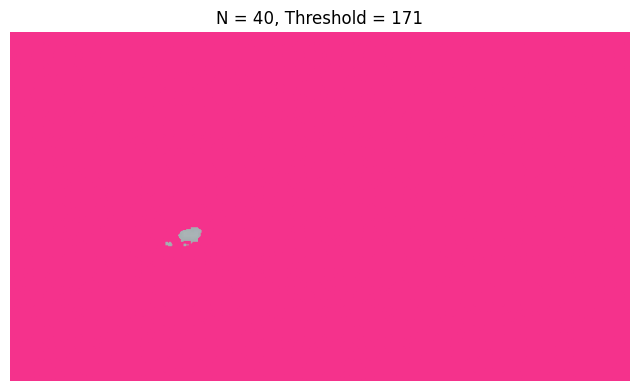

H0 = 1, H1 = 3


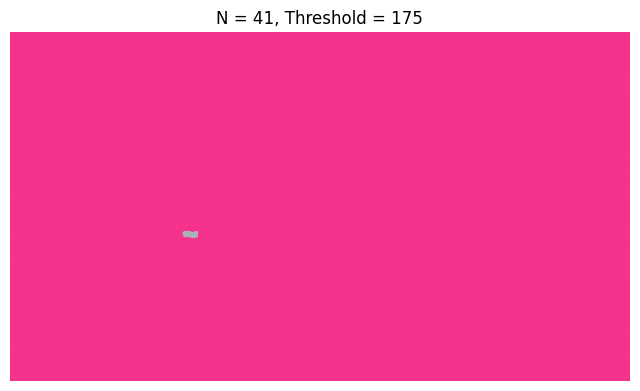

H0 = 1, H1 = 1


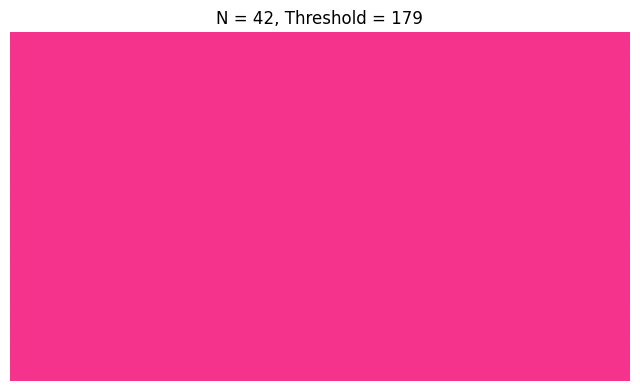

H0 = 1, H1 = 0


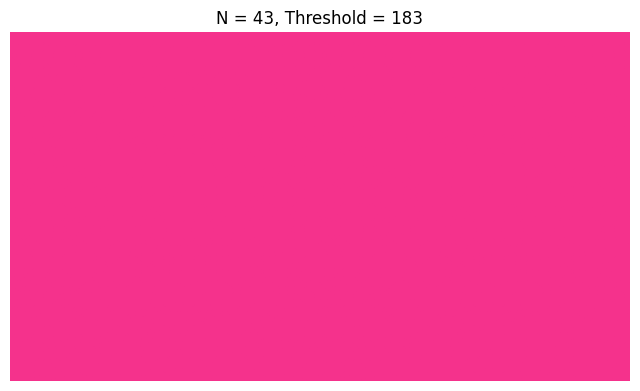

H0 = 1, H1 = 0


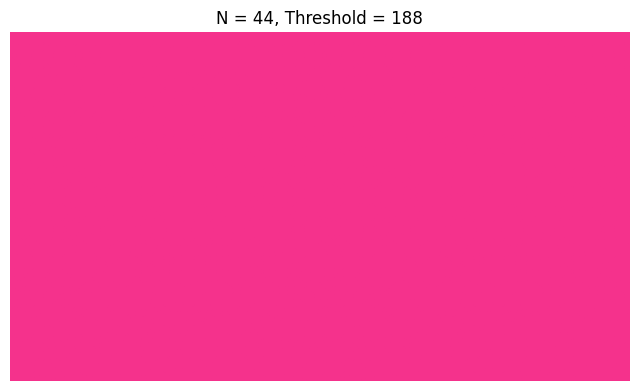

H0 = 1, H1 = 0


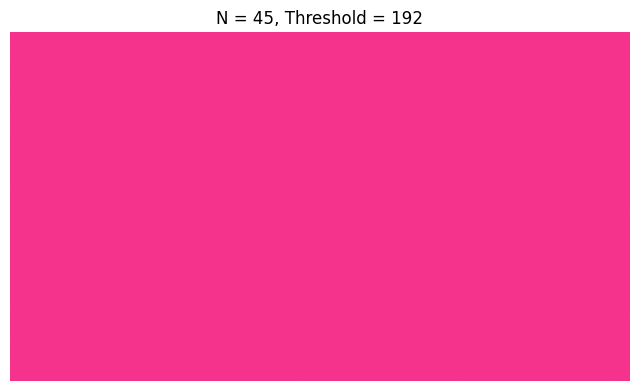

H0 = 1, H1 = 0


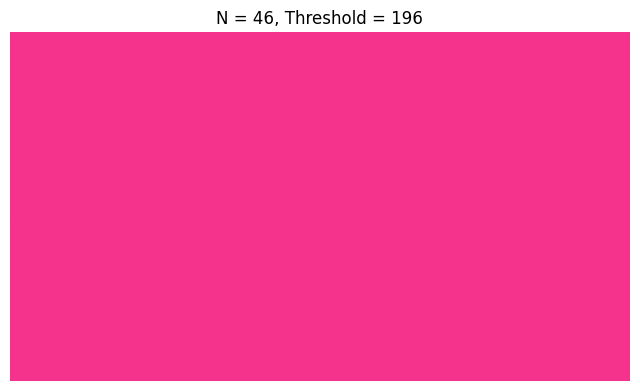

H0 = 1, H1 = 0


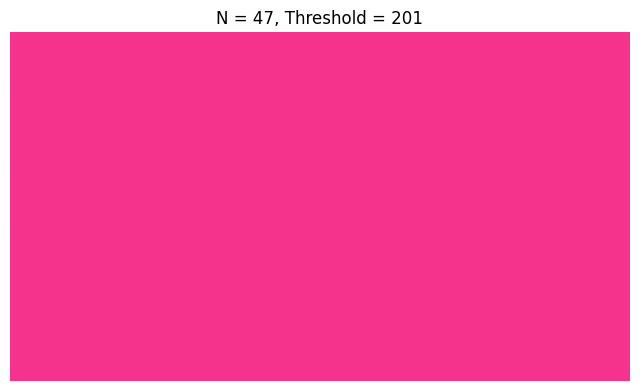

H0 = 1, H1 = 0


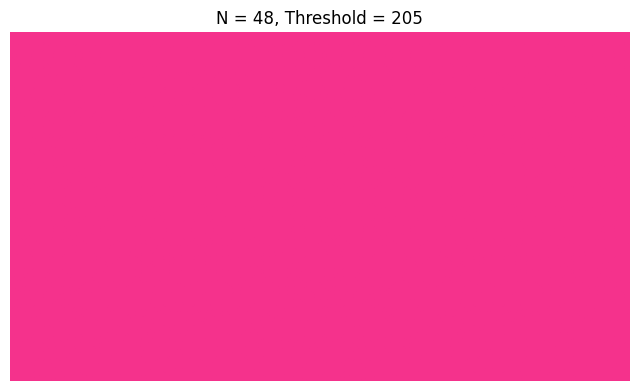

H0 = 1, H1 = 0


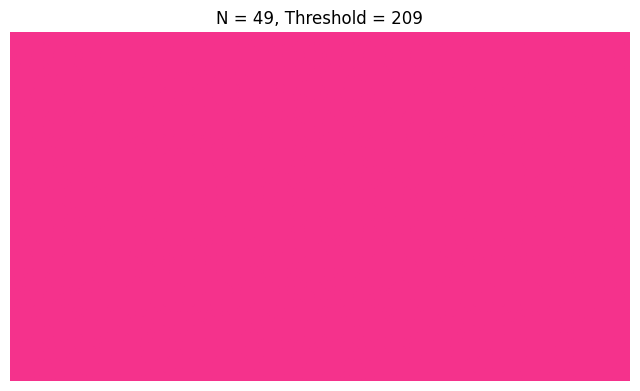

H0 = 1, H1 = 0


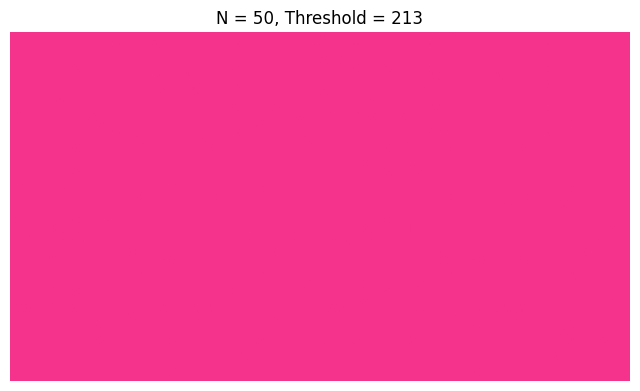

H0 = 1, H1 = 0


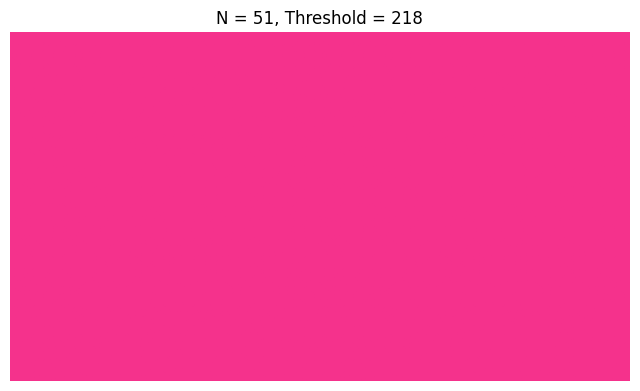

H0 = 1, H1 = 0


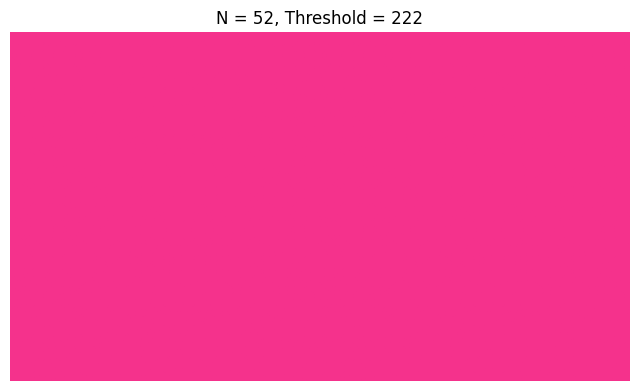

H0 = 1, H1 = 0


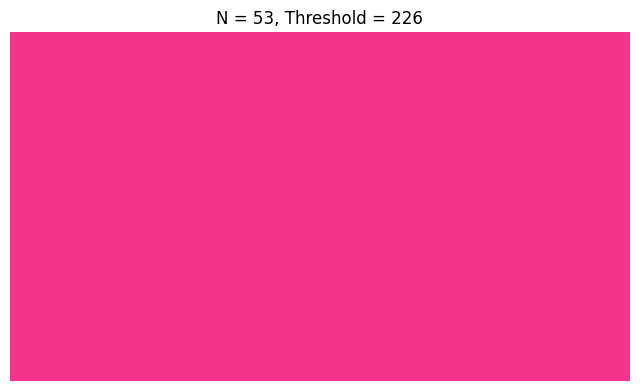

H0 = 1, H1 = 0


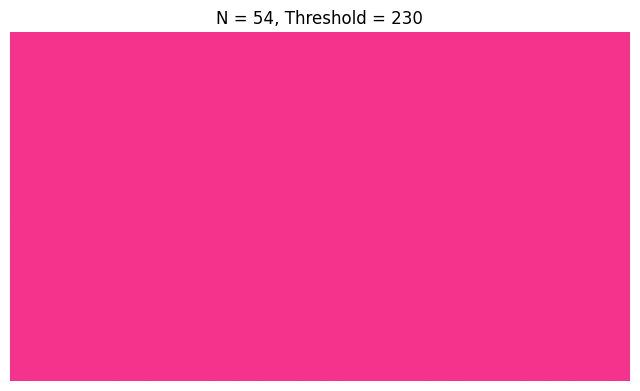

H0 = 1, H1 = 0


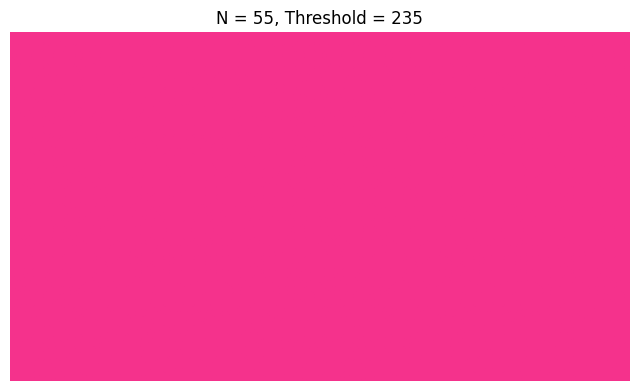

H0 = 1, H1 = 0


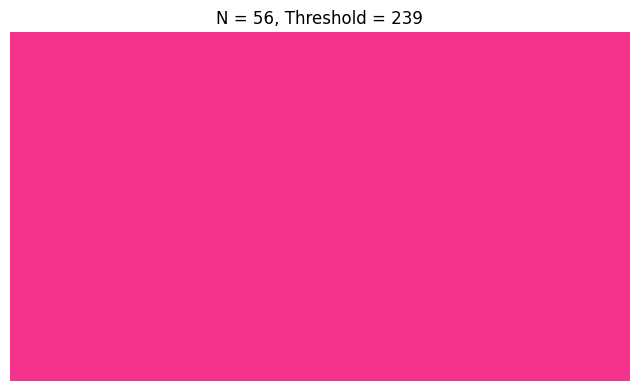

H0 = 1, H1 = 0


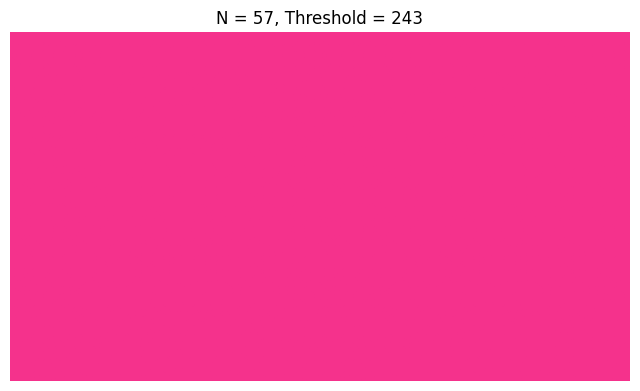

H0 = 1, H1 = 0


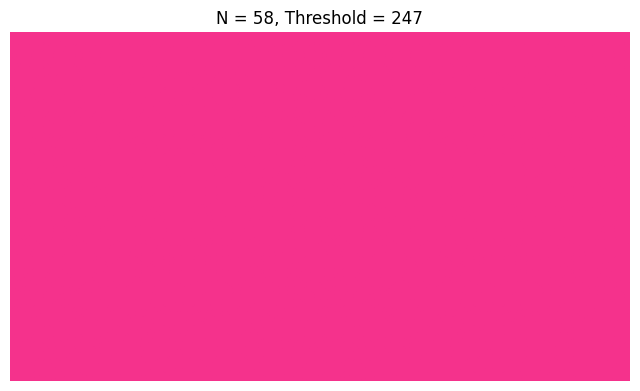

H0 = 1, H1 = 0
[[ 0  0]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 4  0]
 [ 4  0]
 [ 6  4]
 [64  6]
 [68 21]
 [78 44]
 [82 49]
 [56 48]
 [38 56]
 [40 39]
 [34 23]
 [24 32]
 [19 12]
 [20 12]
 [15 14]
 [22 11]
 [13 18]
 [18 18]
 [15 15]
 [13 13]
 [22 18]
 [17 18]
 [37 19]
 [45 44]
 [31 44]
 [25 36]
 [27 20]
 [18 23]
 [17 22]
 [16 28]
 [47 25]
 [24 41]
 [21 37]
 [20 36]
 [ 3 27]
 [ 3 15]
 [ 1  3]
 [ 1  1]
 [ 1  0]
 [ 1  0]
 [ 1  0]
 [ 1  0]
 [ 1  0]
 [ 1  0]
 [ 1  0]
 [ 1  0]
 [ 1  0]
 [ 1  0]
 [ 1  0]
 [ 1  0]
 [ 1  0]
 [ 1  0]
 [ 1  0]
 [ 1  0]
 [ 1  0]
 [ 0  0]]


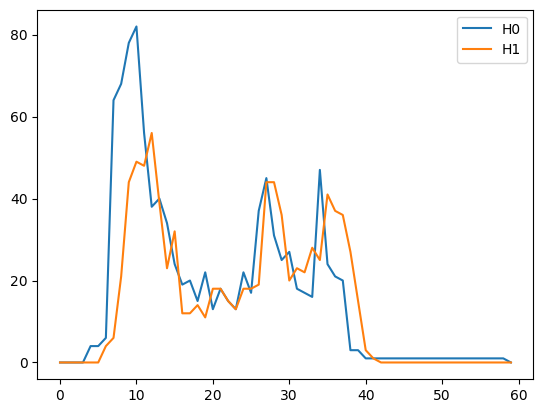

Downloaded image shape: (225, 225, 3)
Successfully downloaded image


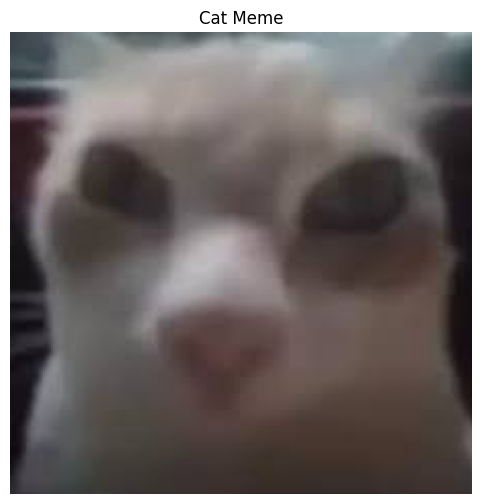

In [ ]:
# Example usage for online compilers
if __name__ == "__main__":
    
    # Download from URL (example URLs)
    print("\n1. Downloading image from URL...")
    
    # Example URLs (replace with actual image URLs)
    test_urls = [
        "https://i.ytimg.com/vi/NfUrT7t7NfI/hq720.jpg?sqp=-oaymwEhCK4FEIIDSFryq4qpAxMIARUAAAAAGAElAADIQj0AgKJD&rs=AOn4CLC6jWZ4vFDWnSSxVOKIU6b48BnZLQ",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRR0TFUS4LqtvmTbjemGEKMMrd85Ut1D1VWz-jiA-EscC4NIb9vPnt4tlJBYCGfBWiVDRw&usqp=CAU",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT-CUBSR2P5PuLYDQOl_N9HxcAO2OEo_0VAYw&s"
    ]

    for url in test_urls:
        img_matrix = download_image_from_url(url)
        if img_matrix is not None:
            print(f"Successfully downloaded image")
            display_matrix_as_image(img_matrix, "Cat Meme")
        
        #convert to grayscale
        img_gray = np.dot(img_matrix[...,:3], [0.2989, 0.5870, 0.1140])
        img_gray = img_gray.astype(np.uint8)

        #compare gray and color images
        compare_original_and_processed(img_matrix, img_gray)
        
        beta = betti_vector_filtration(img_matrix, 60)
        print(beta)
        plt.plot(beta)
        plt.legend(["H0", "H1"])
        plt.show()
    
    